In [ ]:
!pip3 install spectral 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import np_utils

from tensorflow.keras.utils import plot_model
from keras.layers import LeakyReLU

from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [ ]:
## GLOBAL VARIABLES
dataset = 'BO'
test_ratio = 0.9
windowSize = 9

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/Dataset')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA': 
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'PC':
        data = sio.loadmat(os.path.join(data_path, 'Pavia.mat'))['pavia']
        labels = sio.loadmat(os.path.join(data_path, 'Pavia_gt.mat'))['pavia_gt']
    elif name == 'BO':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    return data, labels


In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

In [ ]:
#def applyPCA(X, numComponents=75):
 #   newX = np.reshape(X, (-1, X.shape[2]))
  #  pca = PCA(n_components=numComponents, whiten=True)
   # newX = pca.fit_transform(newX)
    #newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    #return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((1476, 256, 145), (1476, 256))

In [ ]:
K = X.shape[2]
K

145

In [ ]:
K = 100
X,fa = applyFA(X,numComponents=K)

X.shape

(1476, 256, 100)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((3248, 9, 9, 100), (3248,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((324, 9, 9, 100), (2924, 9, 9, 100), (324,), (2924,))

Model and training 


In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K,1)
Xtrain.shape

(324, 9, 9, 100, 1)

In [ ]:
ytrain =keras.utils.to_categorical(ytrain)
ytrain.shape

(324, 14)

In [ ]:
S = windowSize
L = K
if dataset == 'PU' or dataset == 'PC':
    output_units = 9
elif dataset == 'IP' or dataset == 'SA':
     output_units = 16
elif dataset == 'BO':
     output_units = 14

In [ ]:
input_layer = Input((S, S, L,1))

conv_layer= Conv3D(filters=32, kernel_size=(1, 1, 3),dilation_rate=(1,1,3),activation=LeakyReLU(alpha=0.01))(input_layer)
BN_layer=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer)
conv_layer= Conv3D(filters=8, kernel_size=(1, 1, 3),dilation_rate=(1,1,3),activation=LeakyReLU(alpha=0.01))(BN_layer)
BN_layer=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer)





conv_layer1 = Conv3D(filters=4, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer)
BN_layer1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1)
conv_layer1_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer1)
BN_layer1_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_1)
conv_layer1_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer1_1)
BN_layer1_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_2)


conv_layer2 = Conv3D(filters=4, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer)
BN_layer2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2)
conv_layer2_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer2)
BN_layer2_1=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer2_1)
conv_layer2_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer2_1)
BN_layer2_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2_2)

conv_layer3 = Conv3D(filters=4, kernel_size=(3, 3, 7),  dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer)
BN_layer3=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer3)
conv_layer3_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer3)
BN_layer3_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_1)
conv_layer3_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer3_1)
BN_layer3_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_2)

ADD_layer=keras.layers.Add()([BN_layer1_2,BN_layer2_2,BN_layer3_2,BN_layer])


conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(ADD_layer)
BN_layer1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1)
conv_layer1_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer1)
BN_layer1_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_1)
conv_layer1_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,11),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer1_1)
BN_layer1_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer1_2)



conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(ADD_layer)
BN_layer2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2)
conv_layer2_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer2)
BN_layer2_1=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer2_1)
conv_layer2_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,7),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer2_1)
BN_layer2_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer2_2)


conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 7),  dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(ADD_layer)
BN_layer3=BatchNormalization(momentum=0.95,epsilon=1e-5)(conv_layer3)
conv_layer3_1 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer3)
BN_layer3_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_1)
conv_layer3_2 = Conv3D(filters=8, kernel_size=(3, 3, 7),dilation_rate=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer3_1)
BN_layer3_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer3_2)


ADD_layer1=keras.layers.Add()([BN_layer1_2,BN_layer2_2,BN_layer3_2,BN_layer,ADD_layer])




conv_layer4 = Conv3D(filters=8, kernel_size=(1, 1, 1),activation=LeakyReLU(alpha=0.01))(ADD_layer1)
BN_layer4=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4)
conv_layer4_1 = Conv3D(filters=16, kernel_size=(3, 3, 11),strides=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer4)
BN_layer4_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_1)
conv_layer4_2 = Conv3D(filters=32, kernel_size=(1, 1, 1),activation=LeakyReLU(alpha=0.01))(BN_layer4_1)
BN_layer4_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_2)

conv_layer4_3 = Conv3D(filters=32, kernel_size=(1, 1, 1),activation=LeakyReLU(alpha=0.01))(ADD_layer1)
BN_layer4_3=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer4_3)

ResNet_layer1=keras.layers.Add()([BN_layer4_2, BN_layer4_3])



Pool_layer1=keras.layers.AveragePooling3D(pool_size=(2,2,2), padding="same")(ResNet_layer1)


conv_layer5= Conv3D(filters=32, kernel_size=(1,1,1), activation=LeakyReLU(alpha=0.01))(Pool_layer1)
BN_layer5=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5)
conv_layer5_1 = Conv3D(filters=64, kernel_size=(3,3,3),padding='same',activation=LeakyReLU(alpha=0.01))(BN_layer5)
BN_layer5_1=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_1)
conv_layer5_2 = Conv3D(filters=128, kernel_size=(1,1,1), activation=LeakyReLU(alpha=0.01))(BN_layer5_1)
BN_layer5_2=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_2)


conv_layer5_3= Conv3D(filters=128, kernel_size=(1,1,1),padding='same',activation=LeakyReLU(alpha=0.01))(Pool_layer1)
BN_layer5_3=BatchNormalization(momentum=0.95, epsilon=1e-5)(conv_layer5_3)

ResNet_layer2=keras.layers.Add()([BN_layer5_2, BN_layer5_3])



Pool_layer2=keras.layers.AveragePooling3D(pool_size=(2,2,2))(ResNet_layer2)


flatten_layer = Flatten()(Pool_layer2)
dense_layer1 = Dense(units=256, activation=LeakyReLU(alpha=0.01))(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation=LeakyReLU(alpha=0.01))(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


#output_layer = Dense(units=output_units, activation='softmax')(flatten_layer)

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
print(S)
print(L)
Xtrain.shape

9
100


(324, 9, 9, 100, 1)

In [ ]:
input_layer

<KerasTensor: shape=(None, 9, 9, 100, 1) dtype=float32 (created by layer 'input_1')>

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 9, 100,   0           []                               
                                1)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 9, 9, 94, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 9, 9, 94, 32  128        ['conv3d[0][0]']                 
 alization)                     )                                                             

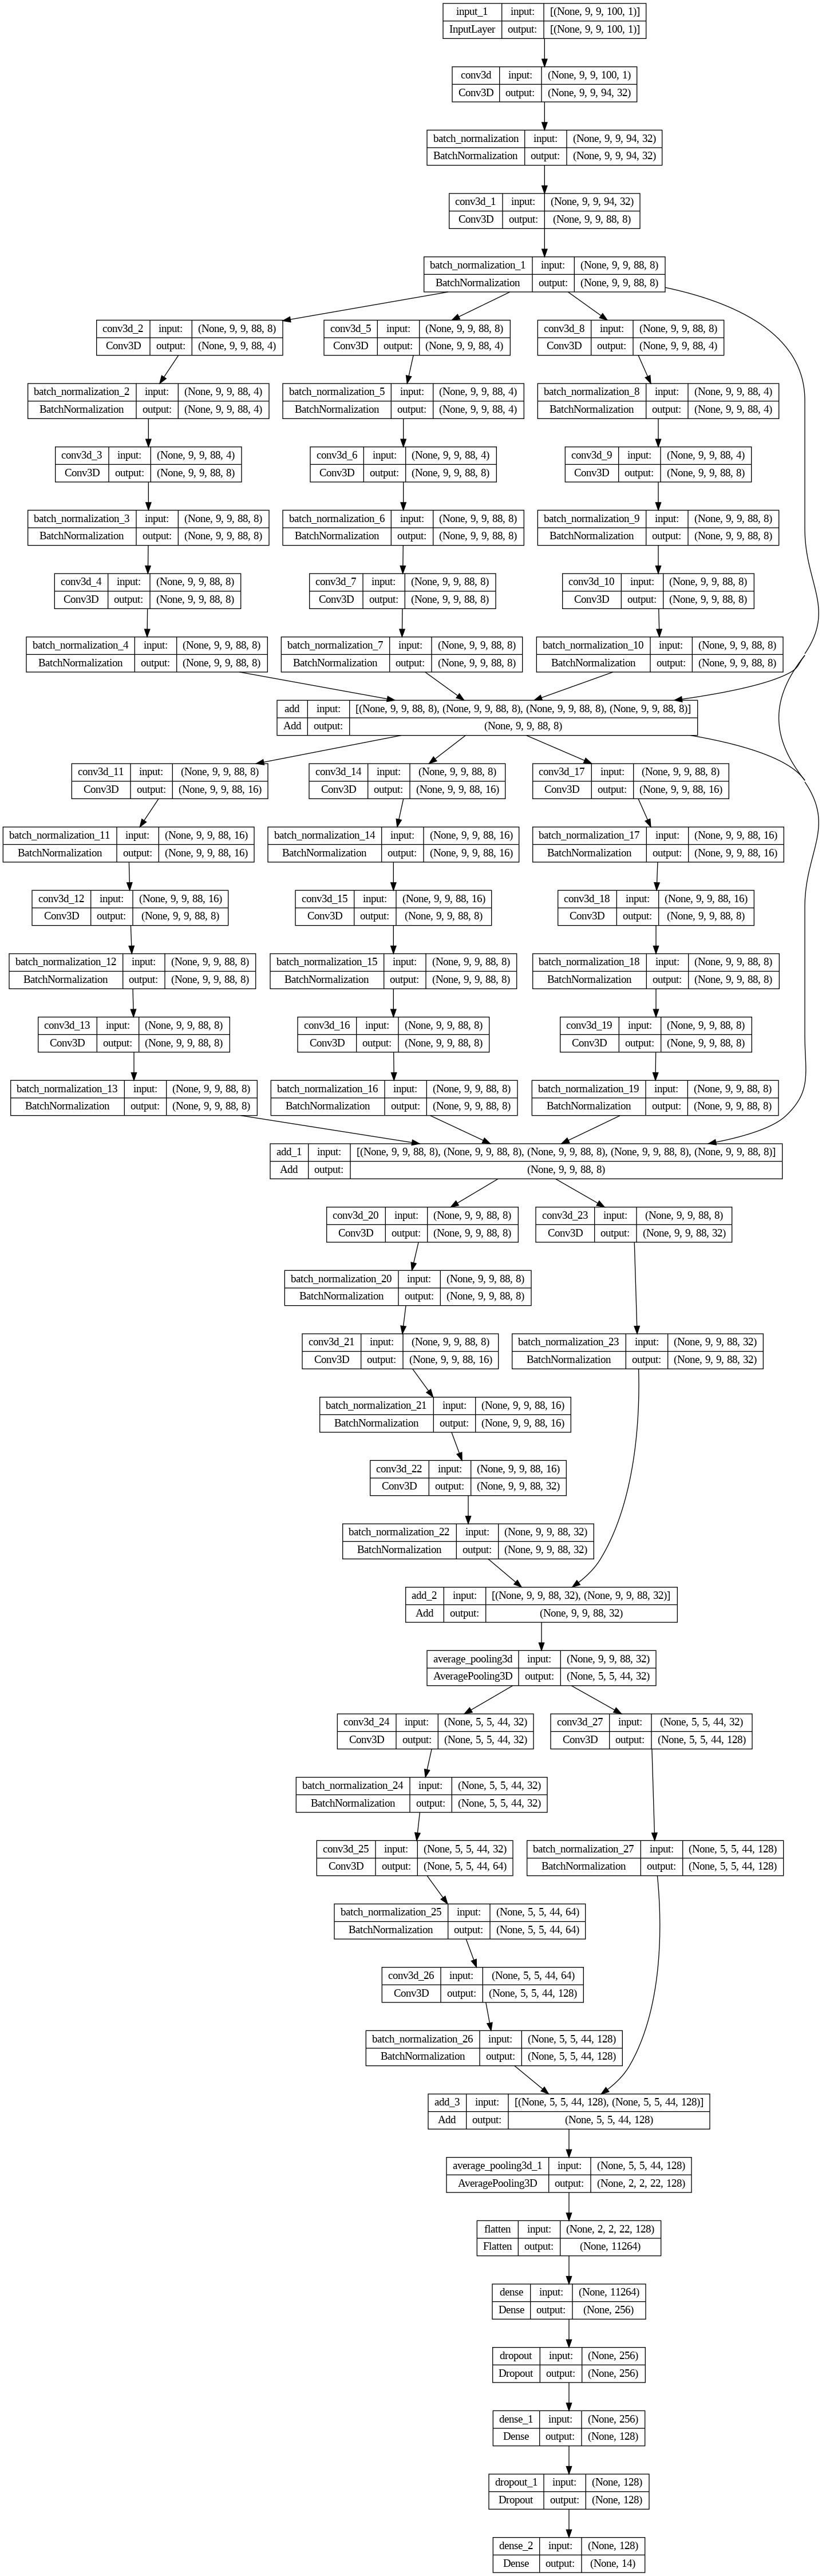

In [ ]:
plot_model(model, to_file='MWS3DCN.png',show_shapes=True)


In [ ]:
# compiling the model
#initial_learning_rate = 0.001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
#sgd = SGD(learning_rate=lr_schedule)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=30, epochs=25,callbacks=callbacks_list)


Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 2.7122 - accuracy: 0.2006
Epoch 1: accuracy improved from -inf to 0.20062, saving model to best-model.hdf5
11/11 [==============================] - 22s 377ms/step - loss: 2.7122 - accuracy: 0.2006
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.4039 - accuracy: 0.5617
Epoch 2: accuracy improved from 0.20062 to 0.56173, saving model to best-model.hdf5
11/11 [==============================] - 3s 250ms/step - loss: 1.4039 - accuracy: 0.5617
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.8241
Epoch 3: accuracy improved from 0.56173 to 0.82407, saving model to best-model.hdf5
11/11 [==============================] - 3s 245ms/step - loss: 0.6595 - accuracy: 0.8241
Epoch 4/25
11/11 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.8364
Epoch 4: accuracy improved from 0.82407 to 0.83642, saving model to best-model.hdf5
11/11 [================

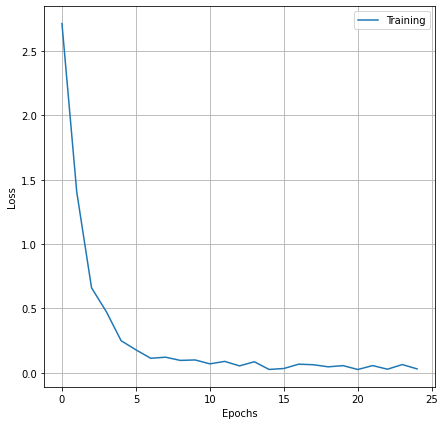

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

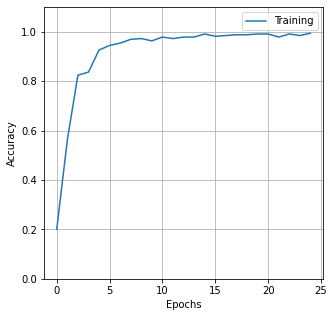

In [ ]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

In [ ]:
# load best weights
model=keras.models.load_model("best-model.hdf5")

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K,1)
Xtest.shape

(2924, 9, 9, 100, 1)

In [ ]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(2924, 14)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test,digits=6)
print(classification)

92/92 [==============================] - 8s 76ms/step
              precision    recall  f1-score   support

           0   0.979839  1.000000  0.989817       243
           1   0.989130  1.000000  0.994536        91
           2   1.000000  1.000000  1.000000       226
           3   0.989796  1.000000  0.994872       194
           4   1.000000  0.888430  0.940919       242
           5   0.970954  0.966942  0.968944       242
           6   1.000000  1.000000  1.000000       233
           7   1.000000  1.000000  1.000000       183
           8   0.996479  1.000000  0.998236       283
           9   1.000000  1.000000  1.000000       223
          10   0.996377  1.000000  0.998185       275
          11   1.000000  1.000000  1.000000       163
          12   0.948819  1.000000  0.973737       241
          13   0.944444  1.000000  0.971429        85

    accuracy                       0.988030      2924
   macro avg   0.986846  0.989669  0.987905      2924
weighted avg   0.988390  0

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'BO':
        target_names = ['Water','Hippo_grass','Floodpain_grasses_1','Floodpain_grasses_2','Reeds','Riparian','Firescar',
                        'Island_interior','Acacia_woodlands','Acacia_shrublands','Acacia_grasslands','Short_mopane',
                        'Mixed_mopane','Exposed_soils']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names,digits=6)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)


92/92 [==============================] - 8s 77ms/step - loss: 0.0408 - accuracy: 0.9880


In [ ]:
classification
print(classification)

                     precision    recall  f1-score   support

              Water   0.979839  1.000000  0.989817       243
        Hippo_grass   0.989130  1.000000  0.994536        91
Floodpain_grasses_1   1.000000  1.000000  1.000000       226
Floodpain_grasses_2   0.989796  1.000000  0.994872       194
              Reeds   1.000000  0.888430  0.940919       242
           Riparian   0.970954  0.966942  0.968944       242
           Firescar   1.000000  1.000000  1.000000       233
    Island_interior   1.000000  1.000000  1.000000       183
   Acacia_woodlands   0.996479  1.000000  0.998236       283
  Acacia_shrublands   1.000000  1.000000  1.000000       223
  Acacia_grasslands   0.996377  1.000000  0.998185       275
       Short_mopane   1.000000  1.000000  1.000000       163
       Mixed_mopane   0.948819  1.000000  0.973737       241
      Exposed_soils   0.944444  1.000000  0.971429        85

           accuracy                       0.988030      2924
          macro avg   

In [ ]:
confusion
print(confusion)

[[243   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  91   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 226   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 194   0   0   0   0   0   0   0   0   0   0]
 [  5   1   0   2 215   7   0   0   1   0   1   0   5   5]
 [  0   0   0   0   0 234   0   0   0   0   0   0   8   0]
 [  0   0   0   0   0   0 233   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 183   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 283   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 223   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 275   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 241   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  85]]


In [ ]:
Test_loss

4.082851856946945

In [ ]:
Test_accuracy

98.80300760269165

In [ ]:
oa

98.8030095759234

In [ ]:
each_acc
print(each_acc)

[100.         100.         100.         100.          88.84297521
  96.69421488 100.         100.         100.         100.
 100.         100.         100.         100.        ]


In [ ]:
aa

98.96694214876032

In [ ]:
kappa

98.70332199933203

In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,fa = applyFA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 [==============================] - 0s 27ms/step


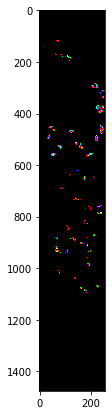

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

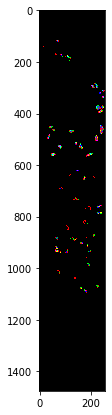

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)